In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

# sklearn
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

## Data

In [2]:
# Import data
data = pd.read_csv('../data/BankChurners.csv')

# Drop last two columns that are not needed
data = data.iloc[:, :-2]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

## Basic Feature Engineering

In [4]:
# Group card Card_Category in two groups (Blue: majority of the observations and Premium
data['Card_Category'] = data['Card_Category'].replace(['Silver', 'Gold', 'Platinum'], 'Premium')
print(data['Card_Category'].value_counts())
print(data['Card_Category'].value_counts(normalize=True))

Card_Category
Blue       9436
Premium     691
Name: count, dtype: int64
Card_Category
Blue       0.931767
Premium    0.068233
Name: proportion, dtype: float64


In [5]:
# Create a new numeric column based on 'Attrition_Flag'
data['Attrited_Customer'] = np.where(data['Attrition_Flag'] == 'Existing Customer', 0, 1)
print(data['Attrited_Customer'].value_counts())
print(data['Attrited_Customer'].value_counts(normalize=True))

Attrited_Customer
0    8500
1    1627
Name: count, dtype: int64
Attrited_Customer
0    0.83934
1    0.16066
Name: proportion, dtype: float64


## Split the data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['CLIENTNUM','Attrition_Flag','Attrited_Customer'],axis=1), data['Attrited_Customer'], test_size=0.3, stratify=data['Attrited_Customer'], random_state=42)

In [7]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7088, 19) (3039, 19) (7088,) (3039,)


## Feature Engineering

In [8]:
# Select categorial columns
categorical_columns = X_train.select_dtypes(include='object').columns

# Select numeric columns
numeric_columns = X_train.select_dtypes(include=['int64','float64']).columns

In [9]:
# Column Transformer
preprocessor = ColumnTransformer([
    ('num',StandardScaler(),numeric_columns),
    ('cat',OneHotEncoder(drop='if_binary',handle_unknown='ignore'),categorical_columns)
])

## Dataframe to store the results

In [10]:
results = pd.DataFrame(columns=['Model','Threshold','Best_params','Accuracy', 'Precision','Recall','F1','ROC_AUC', 'Training_duration'])

## Baseline

In [11]:
# Create the pipeline for the baseline model
pipe_baseline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',LogisticRegression())
])

In [12]:
# Fit the baseline model

start_time = time.time()

pipe_baseline.fit(X_train,y_train)

end_time = time.time()
training_duration = end_time - start_time

In [13]:
## Predict for the baseline
y_pred = pipe_baseline.predict(X_test)

# Predict probabilities for the test set
y_proba = pipe_baseline.predict_proba(X_test)[:, 1]


In [14]:
## Calculate the metrics

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)

In [15]:
# Add metrics to the results DataFrame
new_row = {
    'Model': 'Baseline Model',
    'Threshold':0.5,
    'Best_params':'',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'ROC_AUC': roc_auc,
    'Training_duration': training_duration
}

new_row_df = pd.DataFrame([new_row])

results = pd.concat([results, new_row_df], ignore_index=True)


/var/folders/9f/_b6m_x357pv2yr00rnd6hh4h0000gq/T/ipykernel_92511/3532381764.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row_df], ignore_index=True)


In [16]:
# Print the baseline results
results

,Model,Threshold,Best_params,Accuracy,Precision,Recall,F1,ROC_AUC,Training_duration
0,Baseline Model,0.5,,0.899309,0.763006,0.540984,0.633094,0.914939,0.072297


#### ROC-AUC Curve and Confusion Matrix

In [17]:
## ROC AUC Curve
# y_proba contains the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

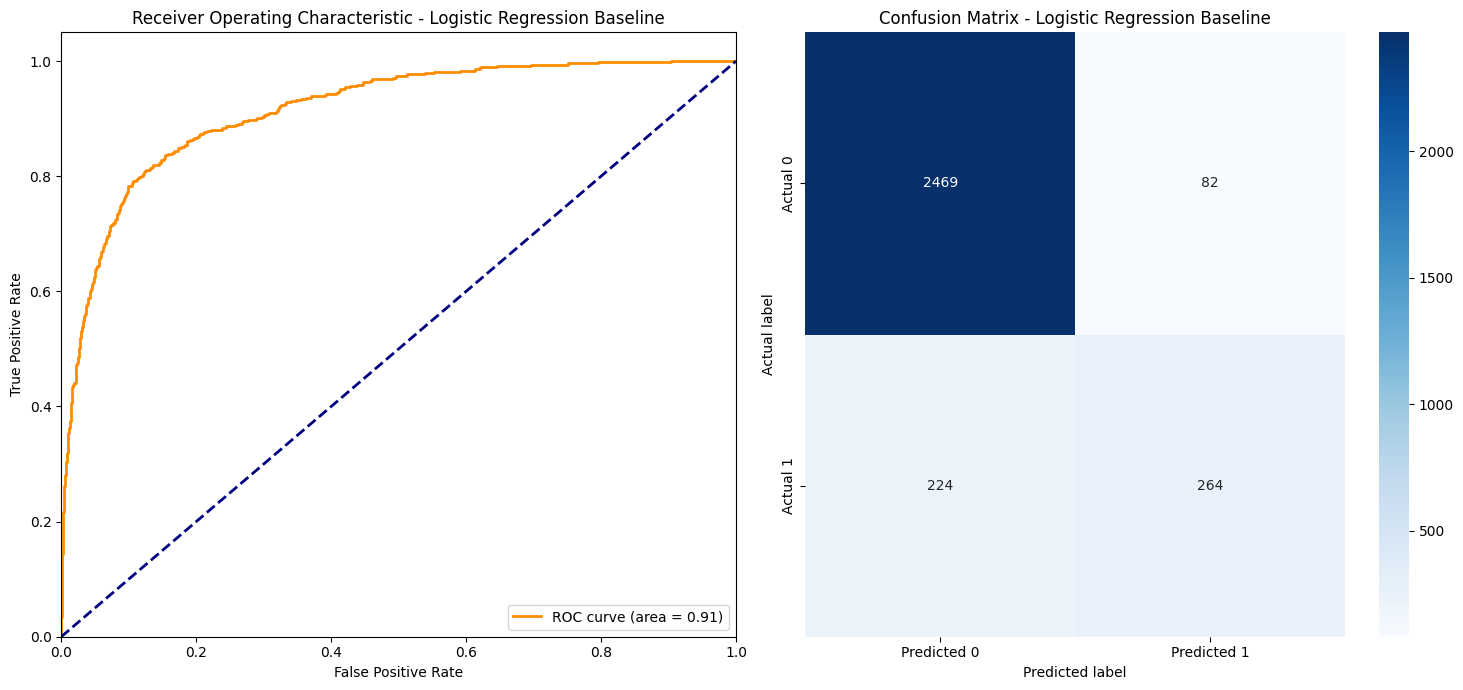

In [19]:
# Plot ROC AUC Curve and Confusion Matrix
# Create a figure for subplots
plt.figure(figsize=(15, 7))

# Subplot 1: ROC AUC Curve
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression Baseline')
plt.legend(loc="lower right")

# Subplot 2: Confusion Matrix
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - Logistic Regression Baseline')

# Adjust layout to make room for the plot titles, etc.
plt.tight_layout()

plt.show()

## Create the models with hyperparameters optimized

In [20]:
def model_creation_optimization(model_name, model, parameters, scoring_metric, threshold, results_df):
    '''
    Inputs: Model, param_grid, scoring
    1. Create the pipeline
    2. Create the GridSearchCV
    3. Fit the model
    4. Predict values and calculate probabilities
    5. Calculate metrics
    6. Add to results DataFrame
    7. Plot the ROC Curve and Plot the cunfusion matrix
    8. Plot feature importance
    '''

    # 1. Create the pipeline
    pipe_model = Pipeline([
        ('preprocessor',preprocessor),
        ('model',model)
    ])

    # 2. Create the GridSearchCV
    grid_search = GridSearchCV(pipe_model, param_grid=parameters[model_name], cv=5, scoring=scoring_metric,n_jobs=-1)

    # 3. Fit grid search on the training data and measure the training duration
    start_time = time.time()
    
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    training_duration = end_time - start_time
    
    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_.named_steps['model']

    # Get the feature names
    feature_names = list(preprocessor.get_feature_names_out())

    # 4. Predict values and calculate probabilities
    
    # Apply custom threshold to determine predictions
    y_proba = grid_search.best_estimator_.predict_proba(X_test)
    y_proba_1 = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    # y_pred = grid_search.best_estimator_.predict(X_test)
    y_pred = (y_proba_1 > threshold).astype(int)
    
    # 5. Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba_1)

    # 6. Add to results DataFrame
    new_row = {
        'Model': model_name,
        'Threshold':threshold,
        'Best_params':best_params,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC_AUC': roc_auc,
        'Training_duration': training_duration
    }

    new_row_df = pd.DataFrame([new_row])

    # 7. Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_1)
    roc_auc = auc(fpr, tpr)
    
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a figure for subplots
    plt.figure(figsize=(15, 7))
    
    # Subplot 1: ROC AUC Curve
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    
    # Subplot 2: Confusion Matrix
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix - {model_name} - Threshold {threshold}')
    
    # Adjust layout to make room for the plot titles, etc.
    plt.tight_layout()
    
    plt.show()

    # 8. Plot feature importance for DecisionTree and LogisticRegression
    if model_name in ['DecisionTree','LogisticRegression']:    
        if model_name == 'DecisionTree':
            importances = best_model.feature_importances_
        elif model_name == 'LogisticRegression':
            importances = best_model.coef_[0]
    
        # Create the DataFrame with feature names and their importances
        feature_importance = pd.DataFrame(zip(feature_names, importances), columns=['Feature', 'Importance'])
        feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

    
        if model_name == 'DecisionTree':
            # Use top 10 features for Decision Tree
            top_features = feature_importance.head(10)
        elif model_name == 'LogisticRegression':
            # Use top 5 and bottom 5 features for Logistic Regression
            top_features = pd.concat([feature_importance.head(5), feature_importance.tail(5)])
        
        # Create a figure and a set of subplots
        fig, axs = plt.subplots(1, 2, figsize=(15, 8))
        
        # Plotting feature importances
        sns.barplot(data=top_features, x='Importance', y='Feature', ax=axs[0], dodge=False)
        axs[0].set_title(f"{'Top 10' if model_name == 'DecisionTree' else 'Top and Bottom 5'} Important Features for {model_name}")
        axs[0].set_xlabel('Feature Importance')
        axs[0].set_ylabel('Features')
        
        # Adding feature importance table
        axs[1].axis('off')  # Hide the axis for the table
        tbl = axs[1].table(cellText=feature_importance.values, colLabels=feature_importance.columns, loc='center')
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(10)
        tbl.scale(1.2, 1.2)  # You can adjust the scaling as needed
        
        plt.tight_layout()
        plt.show()
    
    return new_row_df



## Defining the models and Parameters

In [21]:
# Grid of values to search for Logistic Regression
param_grid = {
    'DecisionTree': {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [None, 3, 5, 10, 20, 30, 40, 50], 'model__min_samples_split': [2, 5, 10],
                     'model__min_samples_leaf': [1, 2, 4], 'model__class_weight': [None, 'balanced']},  # Include 'balanced' to handle class imbalance    
    
    'SVM': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']},
    
    'LogisticRegression': [{'model__solver': ['liblinear'], 'model__penalty': ['l1', 'l2'], 'model__C': [0.01, 0.1, 1, 10, 100]},
        {'model__solver': ['lbfgs'], 'model__penalty': ['l2'], 'model__C': [0.01, 0.1, 1, 10, 100]}]
}

### Logistic Regression

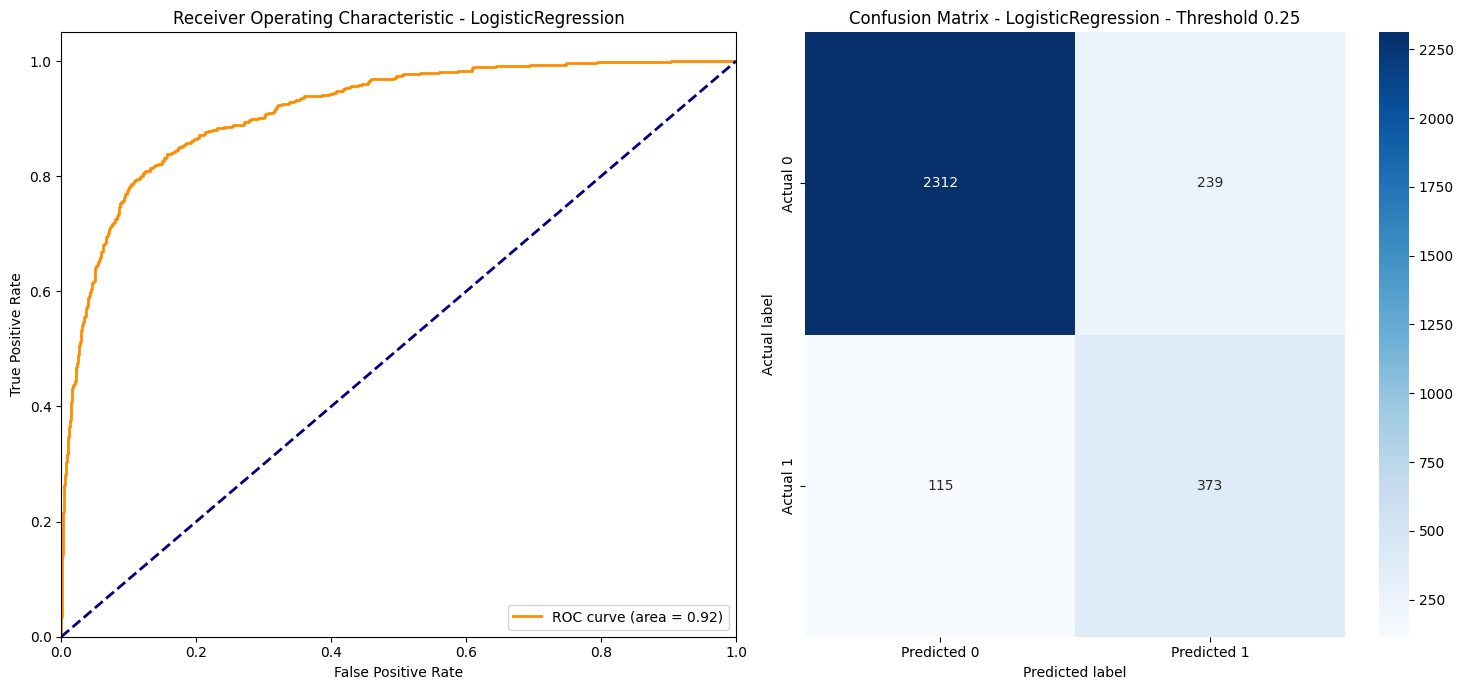

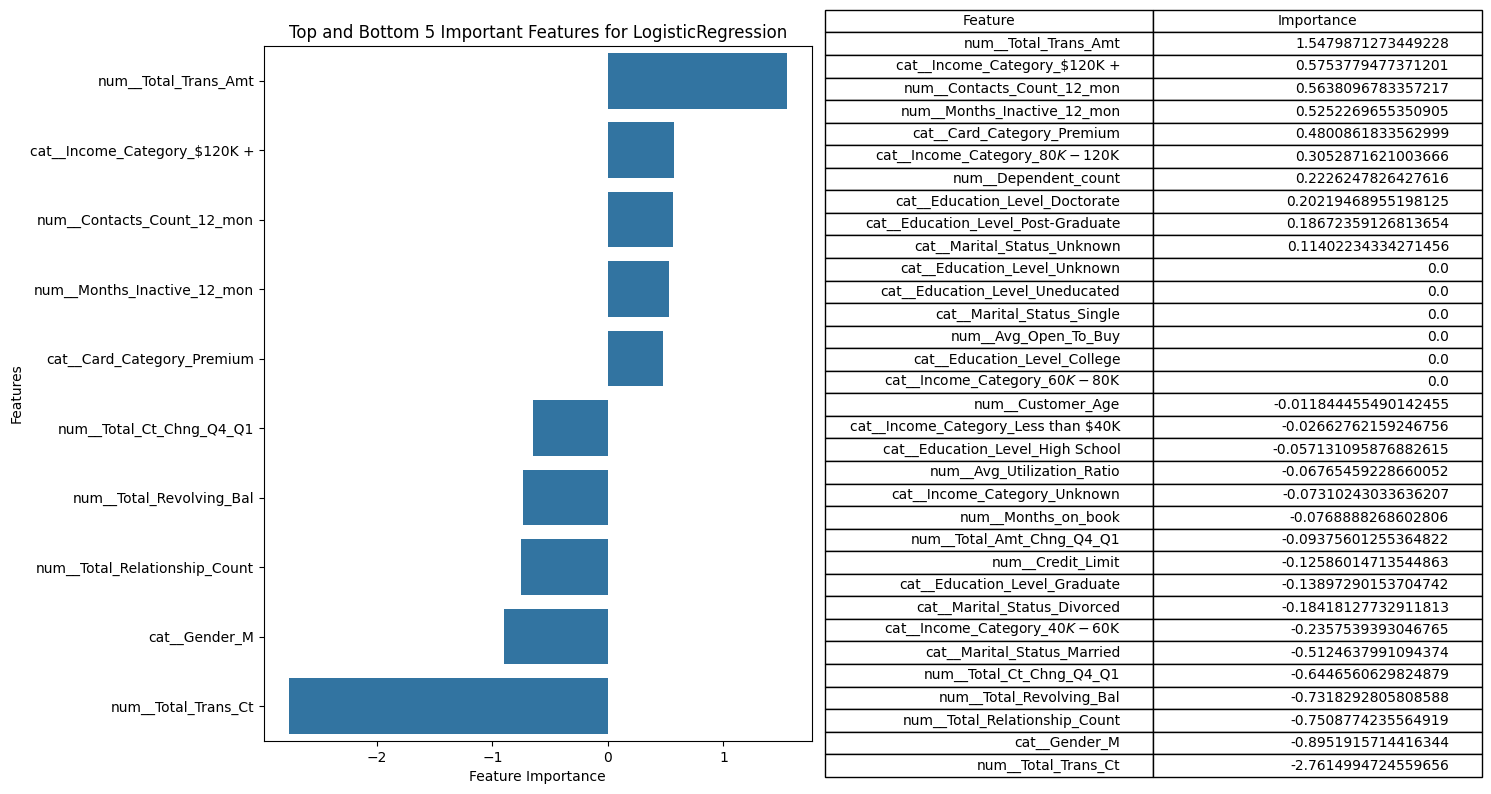

In [22]:
model_result = model_creation_optimization(model_name='LogisticRegression',model=LogisticRegression(max_iter=1000, random_state=42),parameters=param_grid,scoring_metric='f1',threshold=0.25,results_df=results)
results = pd.concat([results, model_result], ignore_index=True)

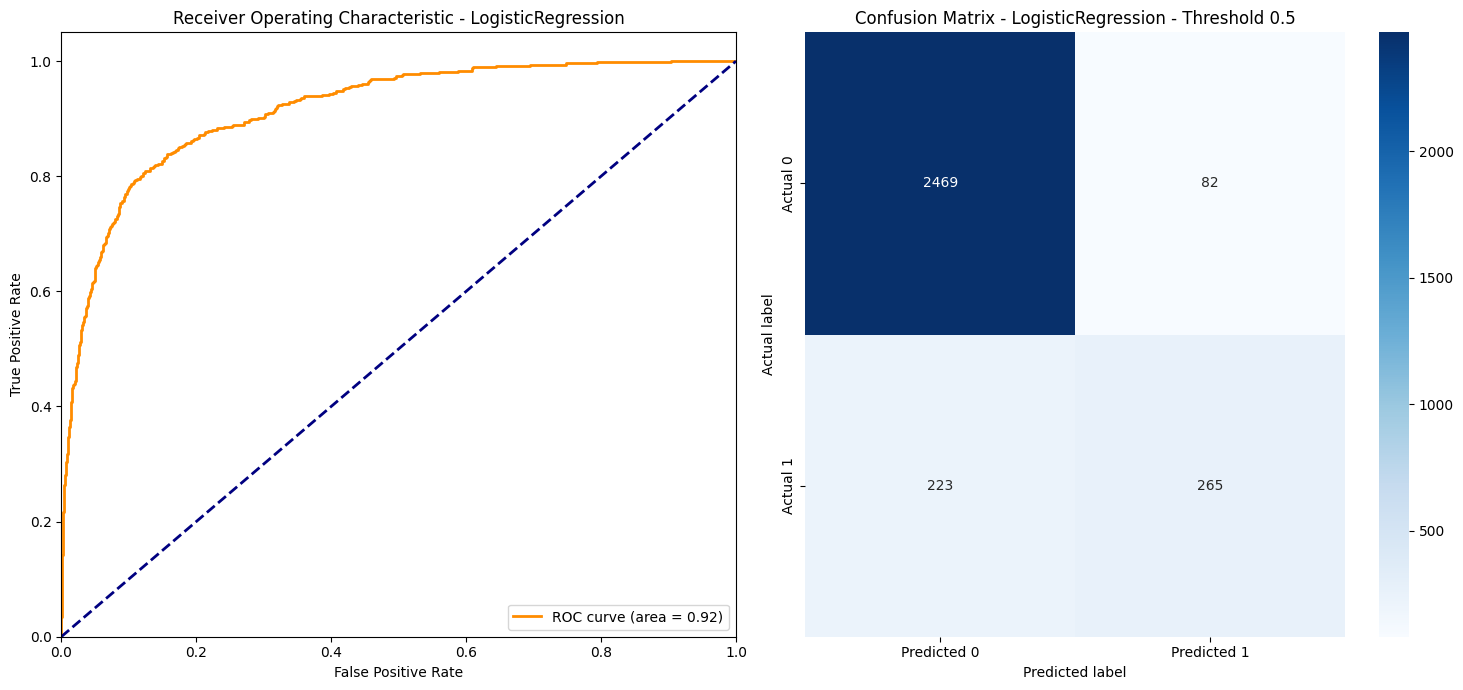

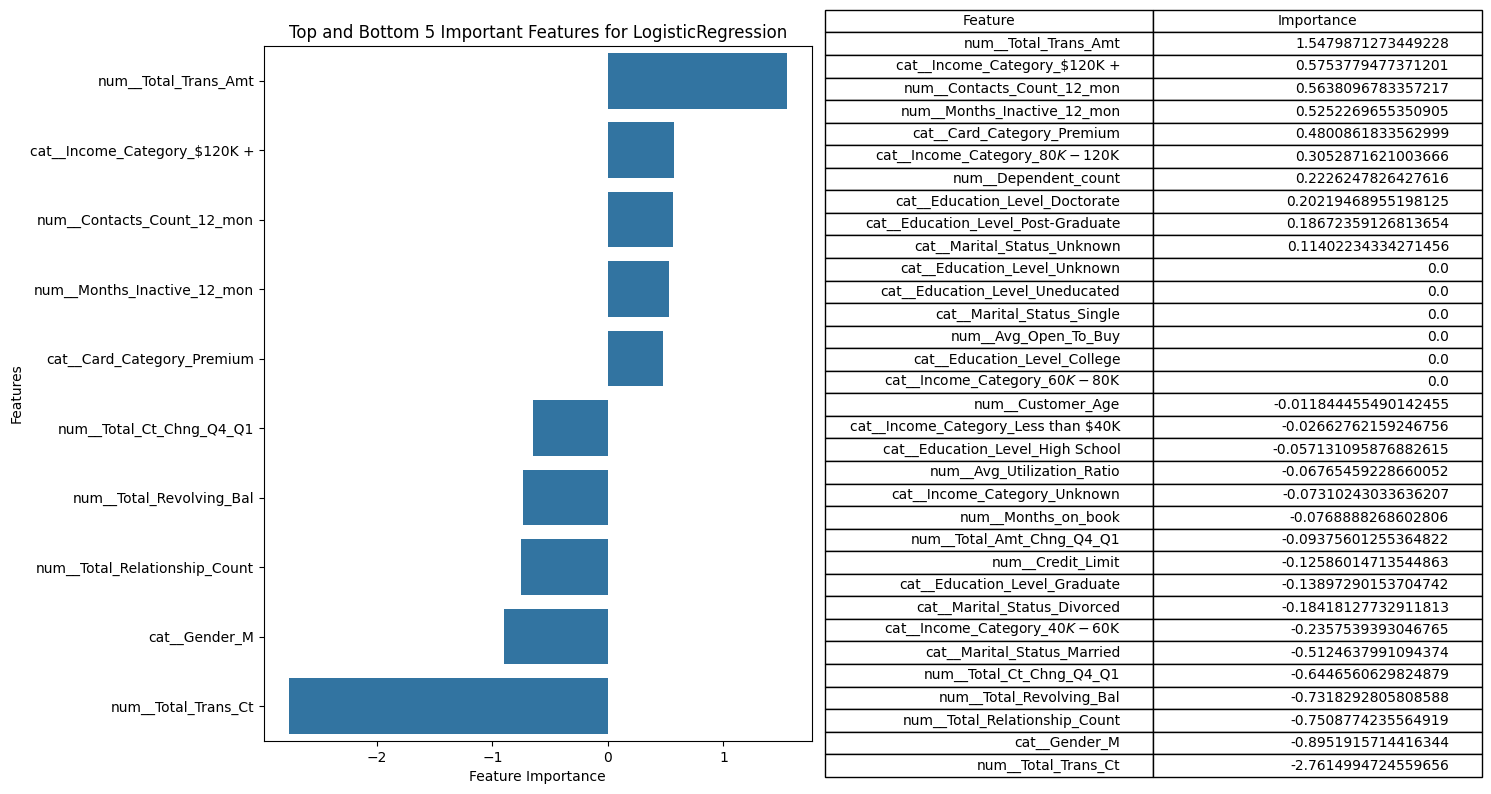

In [23]:
model_result = model_creation_optimization(model_name='LogisticRegression',model=LogisticRegression(max_iter=1000, random_state=42),parameters=param_grid,scoring_metric='f1',threshold=0.5,results_df=results)
results = pd.concat([results, model_result], ignore_index=True)

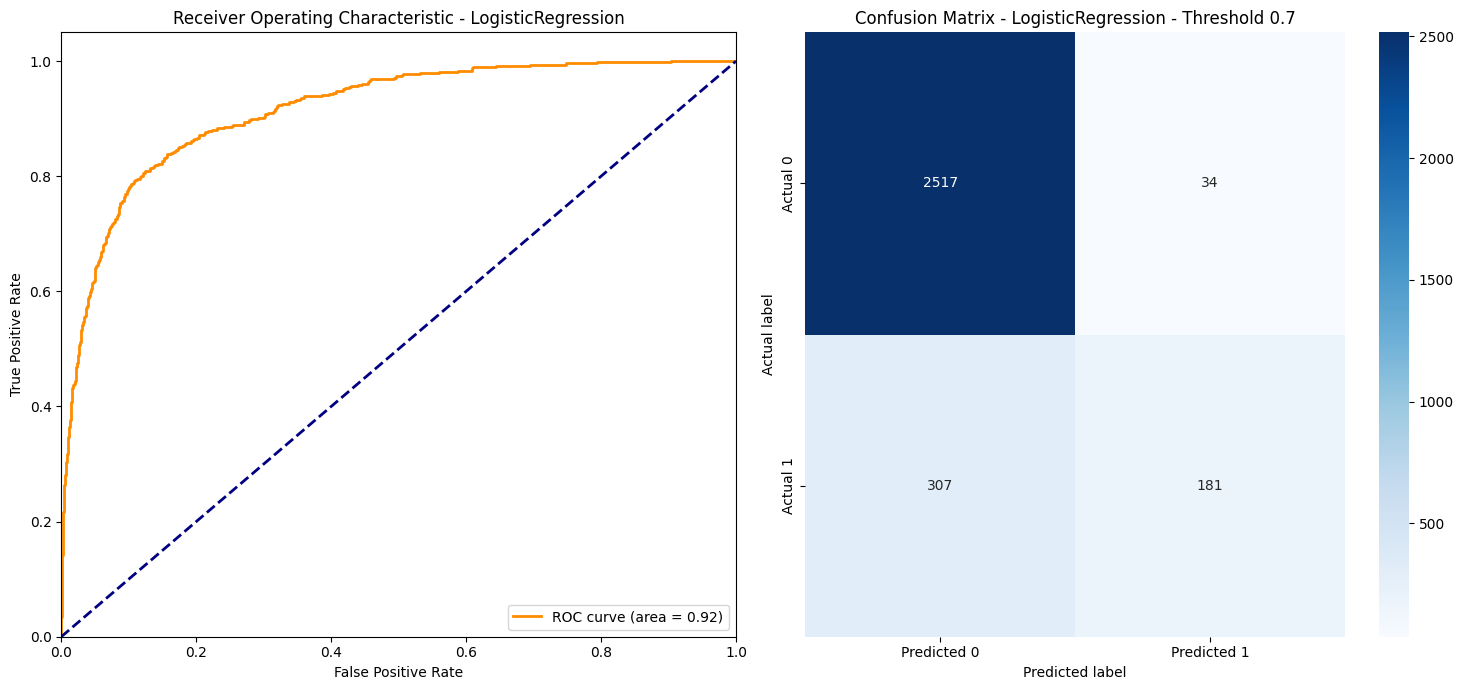

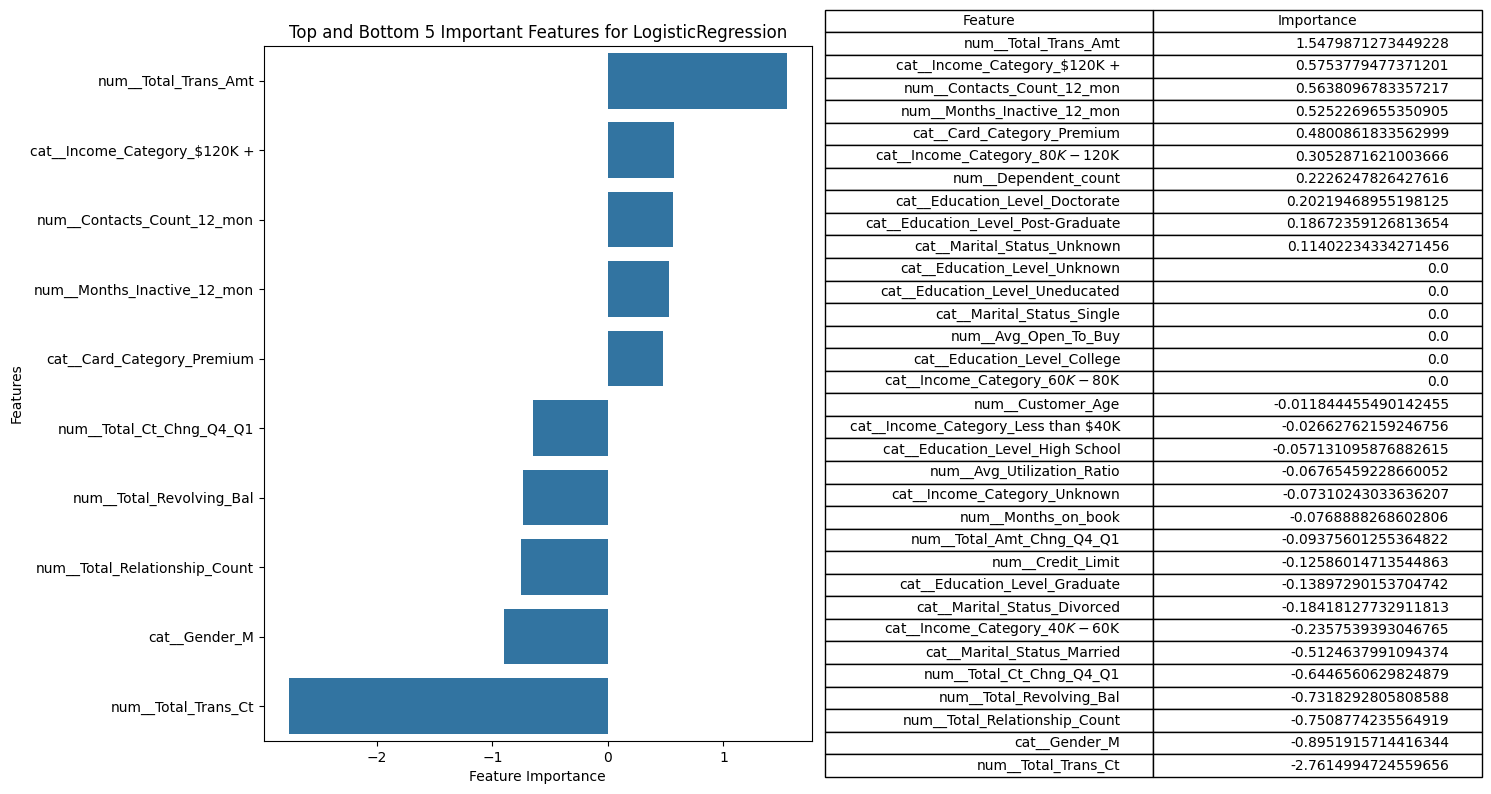

In [24]:
model_result = model_creation_optimization(model_name='LogisticRegression',model=LogisticRegression(max_iter=1000, random_state=42),parameters=param_grid,scoring_metric='f1',threshold=0.7,results_df=results)
results = pd.concat([results, model_result], ignore_index=True)

In [25]:
results

,Model,Threshold,Best_params,Accuracy,Precision,Recall,F1,ROC_AUC,Training_duration
0,Baseline Model,0.50,,0.899309,0.763006,0.540984,0.633094,0.914939,0.072297
1,LogisticRegression,0.25,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.883514,0.609477,0.764344,0.678182,0.915084,8.088990
2,LogisticRegression,0.50,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.899638,0.763689,0.543033,0.634731,0.915084,3.754383
3,LogisticRegression,0.70,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.887792,0.841860,0.370902,0.514936,0.915084,3.841197


### SVM

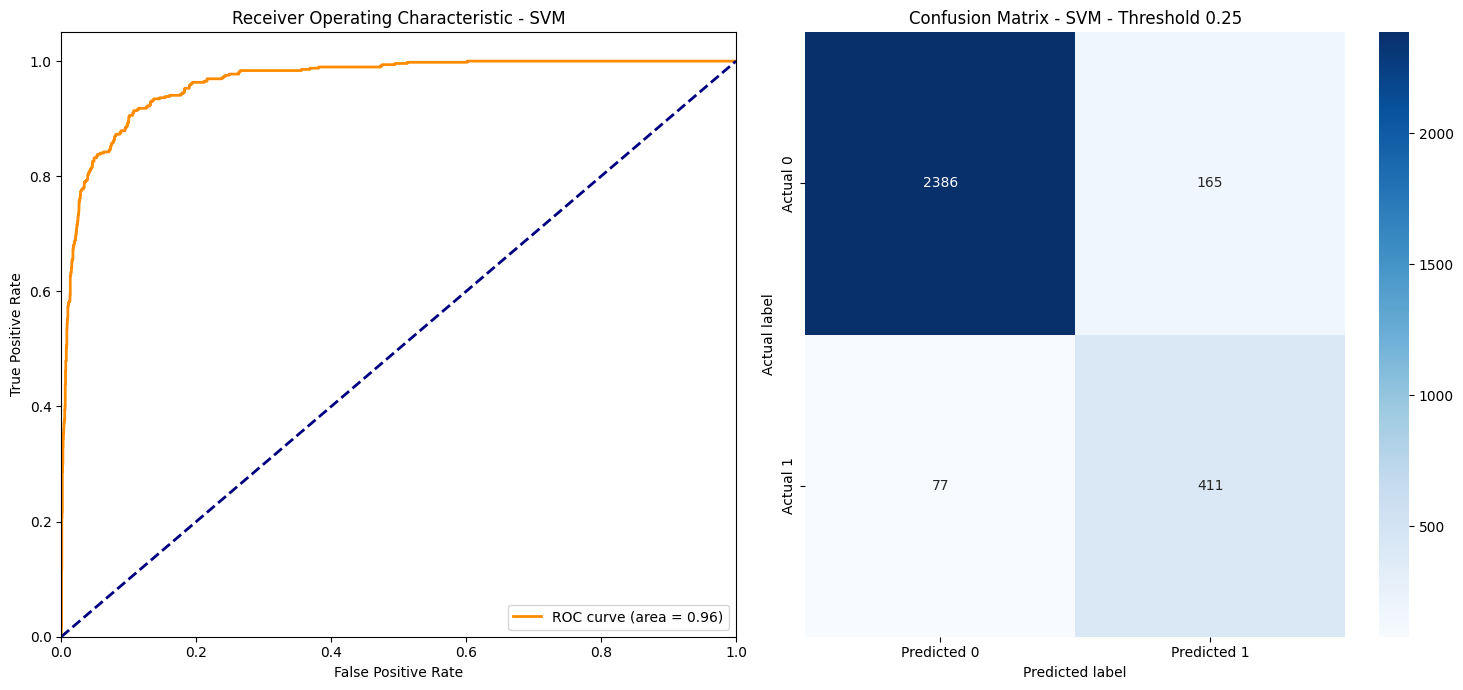

In [26]:
model_result = model_creation_optimization(model_name='SVM',model=SVC(probability=True, class_weight='balanced', random_state=42),
                                           parameters=param_grid,scoring_metric='f1',threshold=0.25,results_df=results)

results = pd.concat([results, model_result], ignore_index=True)

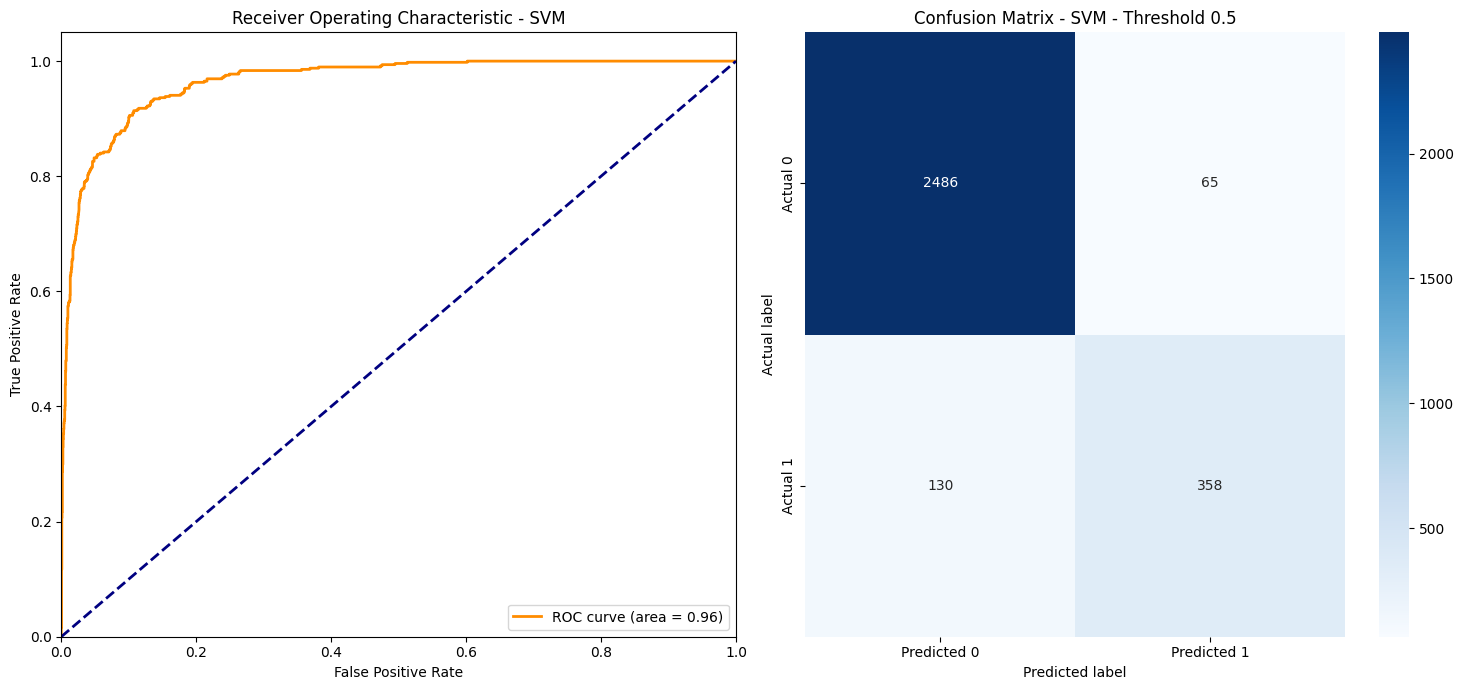

In [27]:
model_result = model_creation_optimization(model_name='SVM',model=SVC(probability=True, class_weight='balanced', random_state=42),
                                           parameters=param_grid,scoring_metric='f1',threshold=0.5,results_df=results)

results = pd.concat([results, model_result], ignore_index=True)

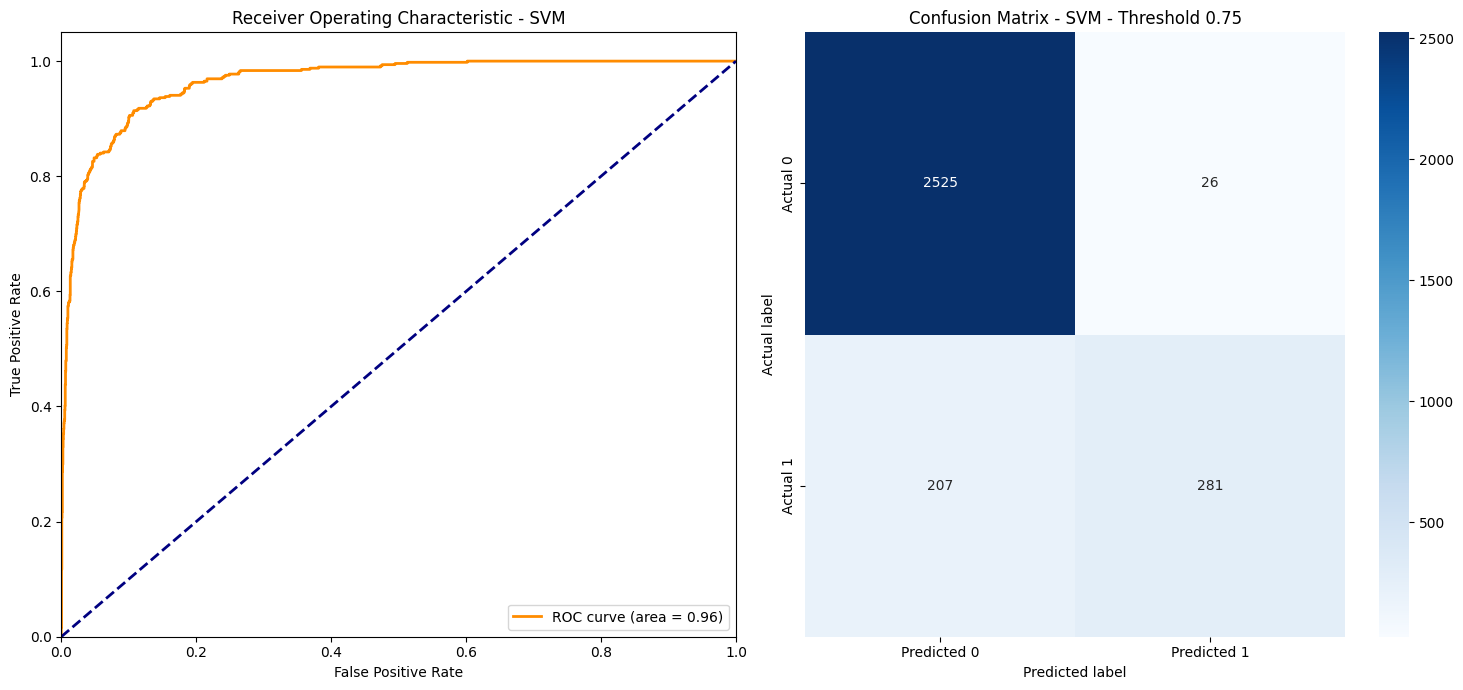

In [28]:
model_result = model_creation_optimization(model_name='SVM',model=SVC(probability=True, class_weight='balanced', random_state=42),
                                           parameters=param_grid,scoring_metric='f1',threshold=0.75,results_df=results)

results = pd.concat([results, model_result], ignore_index=True)

In [29]:
results

,Model,Threshold,Best_params,Accuracy,Precision,Recall,F1,ROC_AUC,Training_duration
0,Baseline Model,0.50,,0.899309,0.763006,0.540984,0.633094,0.914939,0.072297
1,LogisticRegression,0.25,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.883514,0.609477,0.764344,0.678182,0.915084,8.088990
2,LogisticRegression,0.50,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.899638,0.763689,0.543033,0.634731,0.915084,3.754383
3,LogisticRegression,0.70,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.887792,0.841860,0.370902,0.514936,0.915084,3.841197
4,SVM,0.25,"{'model__C': 10, 'model__kernel': 'rbf'}",0.920369,0.713542,0.842213,0.772556,0.964798,149.800629
5,SVM,0.50,"{'model__C': 10, 'model__kernel': 'rbf'}",0.935834,0.846336,0.733607,0.785950,0.964798,145.800579
6,SVM,0.75,"{'model__C': 10, 'model__kernel': 'rbf'}",0.923330,0.915309,0.575820,0.706918,0.964798,147.617716


## Decision Tree

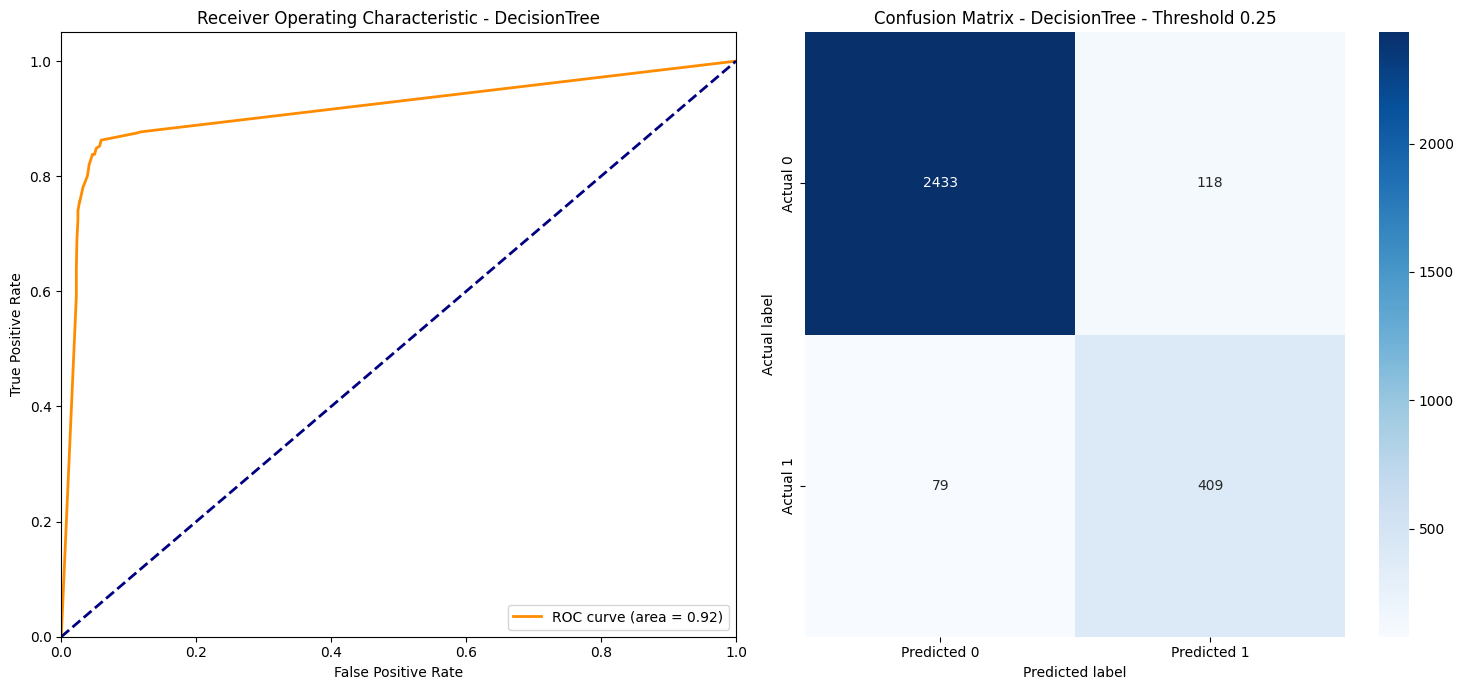

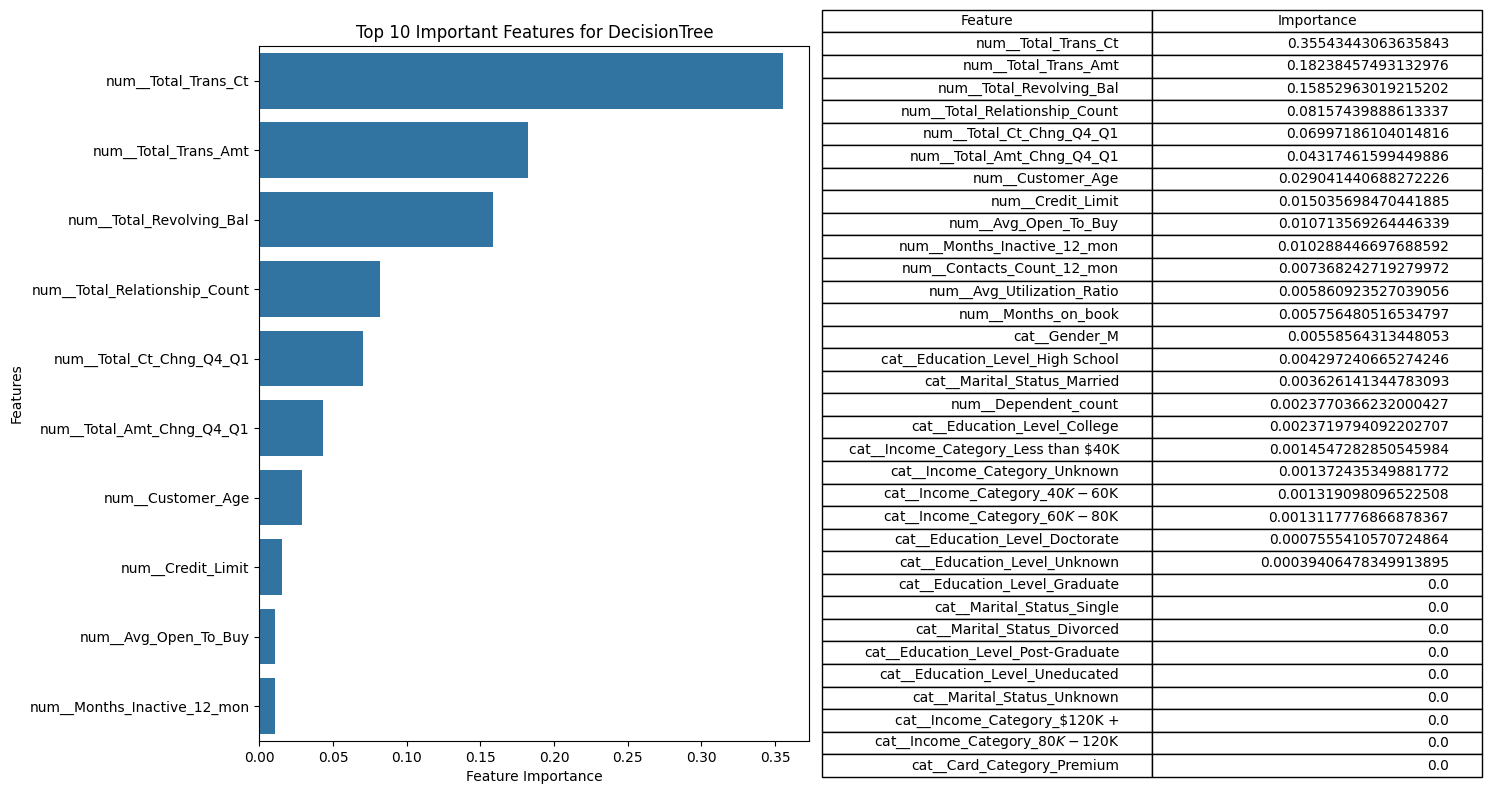

In [30]:
model_result = model_creation_optimization(model_name='DecisionTree',model=DecisionTreeClassifier(random_state=42),parameters=param_grid,scoring_metric='f1',threshold=0.25,results_df=results)
results = pd.concat([results, model_result], ignore_index=True)

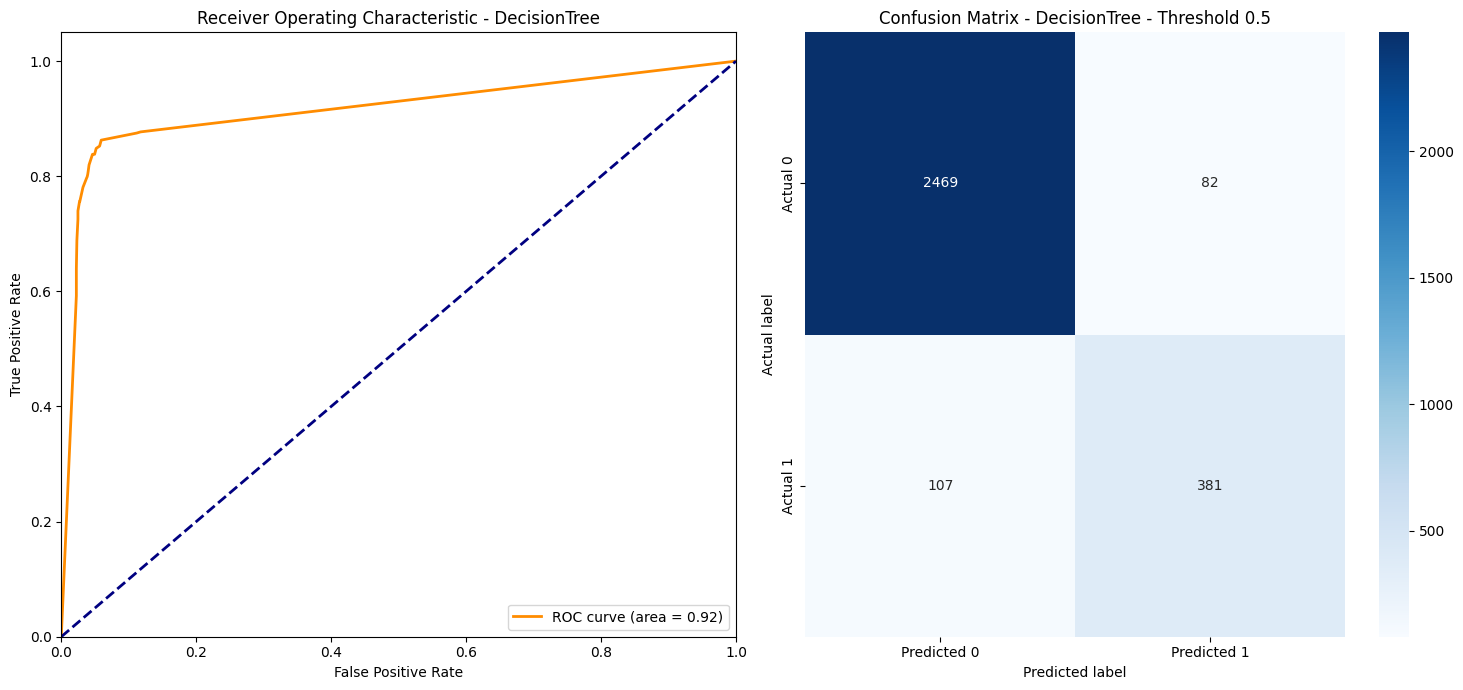

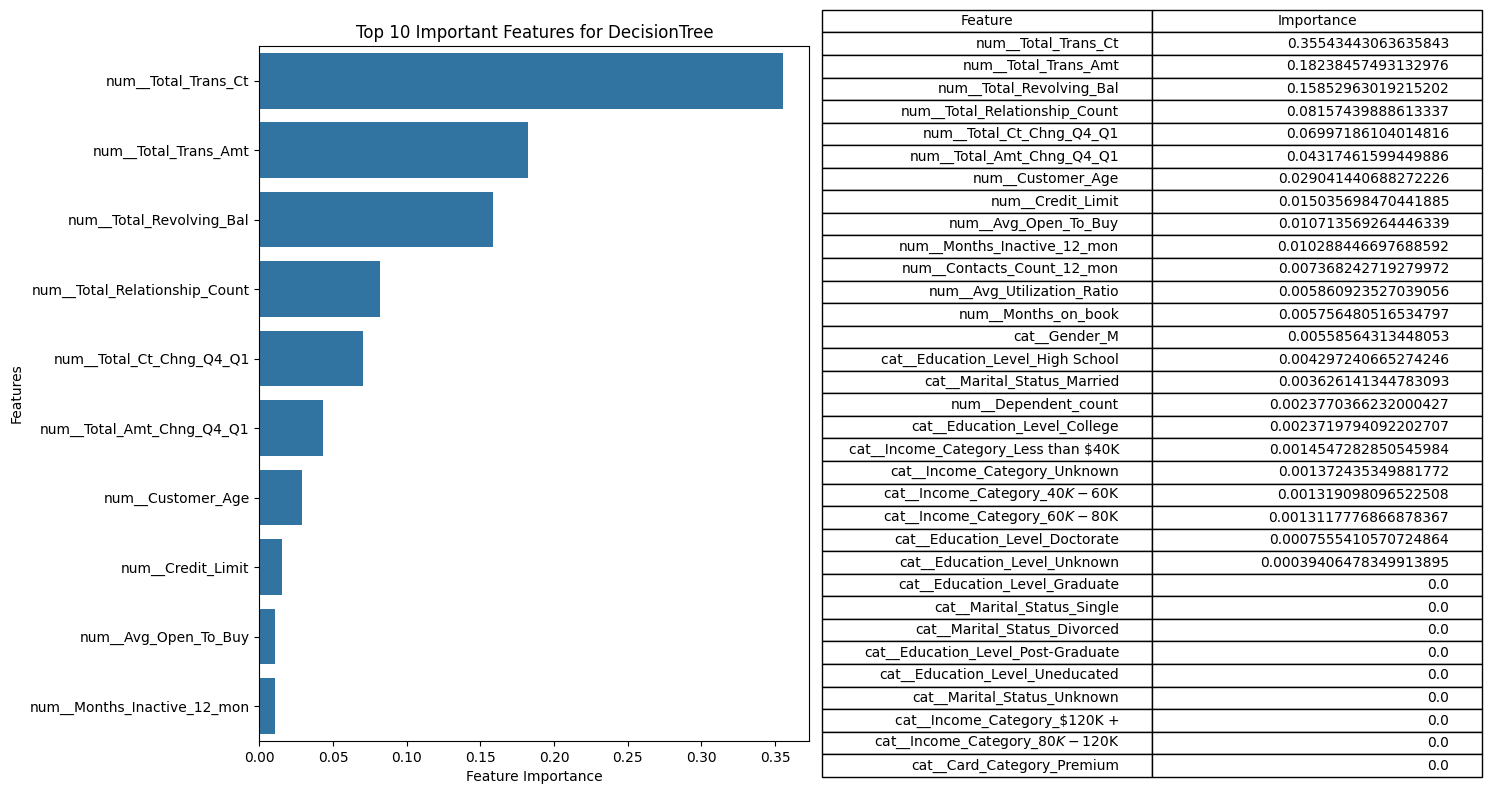

In [31]:
model_result = model_creation_optimization(model_name='DecisionTree',model=DecisionTreeClassifier(random_state=42),parameters=param_grid,scoring_metric='f1',threshold=0.5,results_df=results)
results = pd.concat([results, model_result], ignore_index=True)

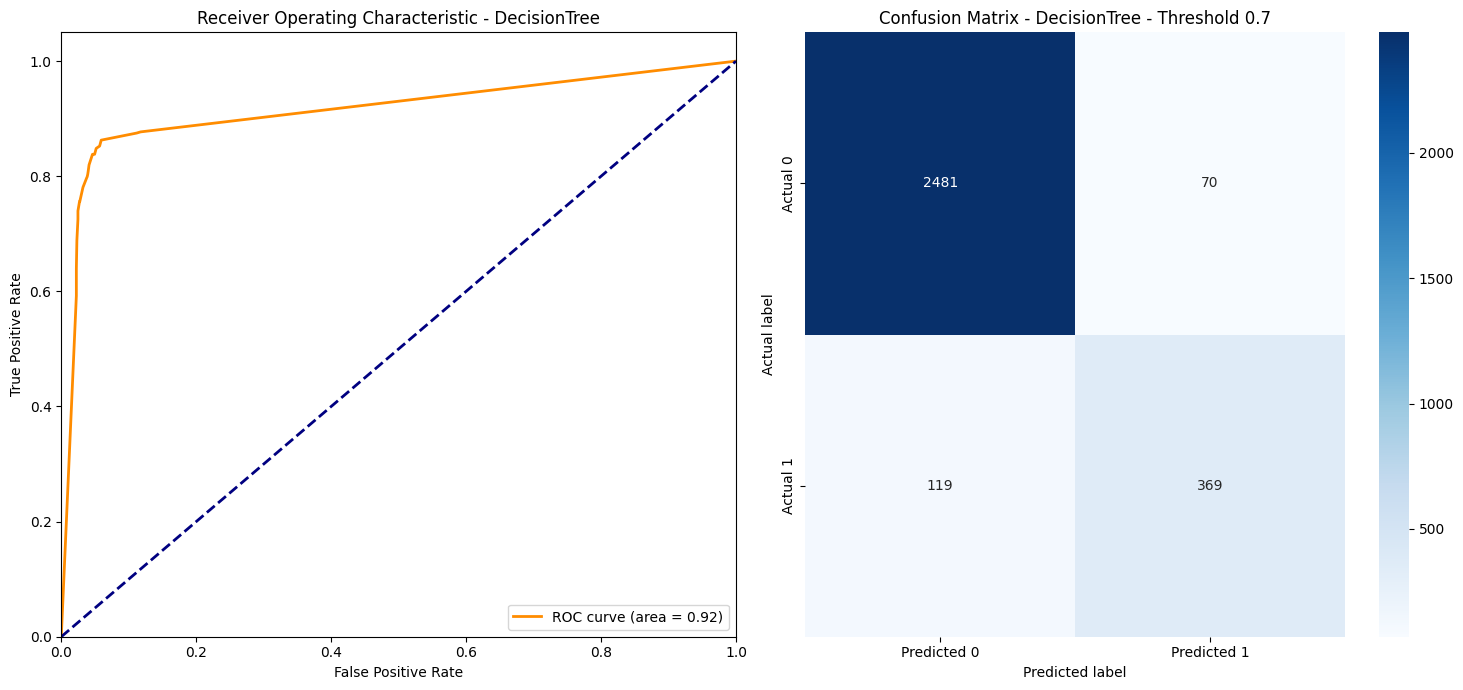

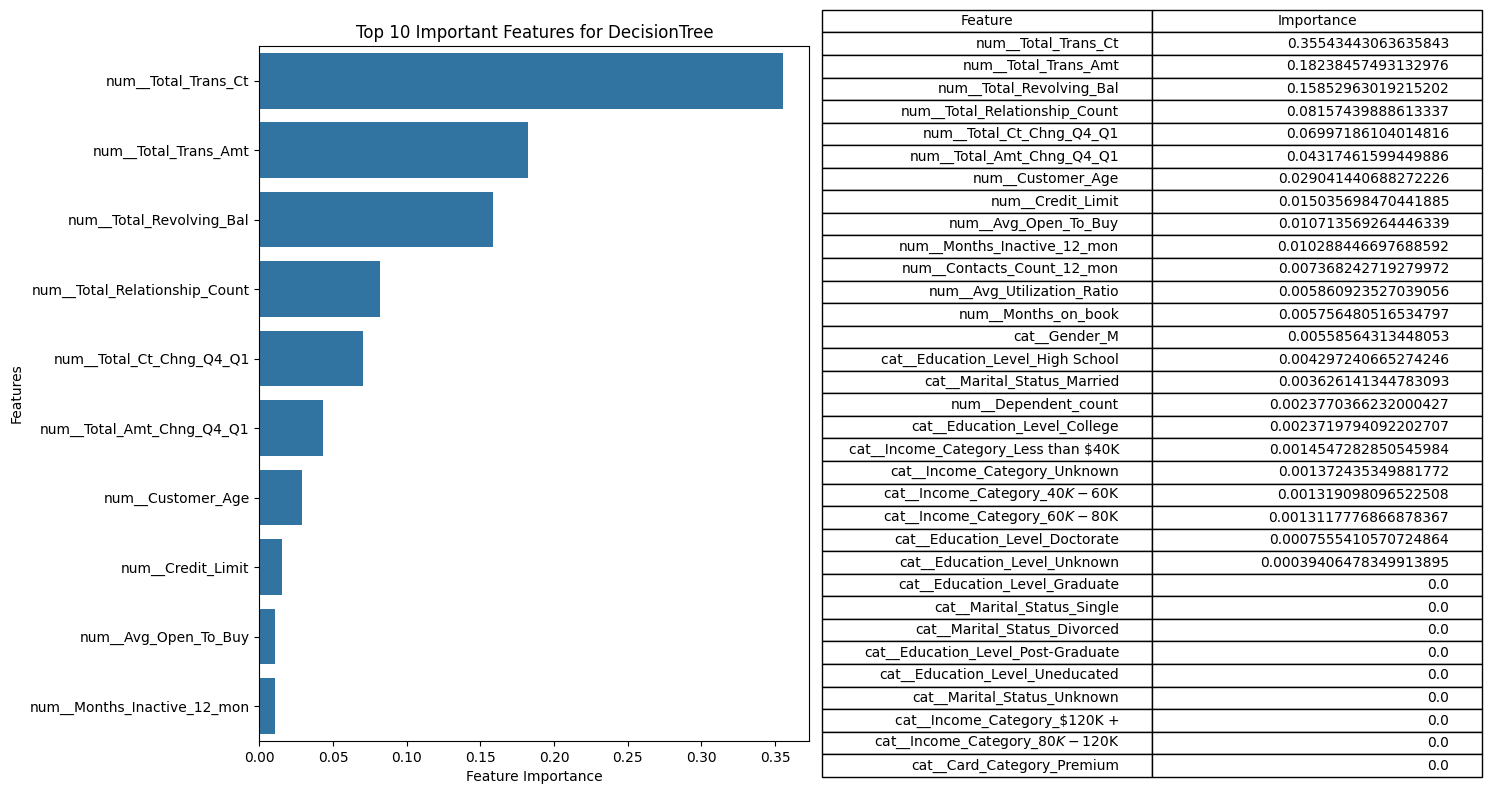

In [32]:
model_result = model_creation_optimization(model_name='DecisionTree',model=DecisionTreeClassifier(random_state=42),parameters=param_grid,scoring_metric='f1',threshold=0.7,results_df=results)
results = pd.concat([results, model_result], ignore_index=True)

In [33]:
results

,Model,Threshold,Best_params,Accuracy,Precision,Recall,F1,ROC_AUC,Training_duration
0,Baseline Model,0.50,,0.899309,0.763006,0.540984,0.633094,0.914939,0.072297
1,LogisticRegression,0.25,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.883514,0.609477,0.764344,0.678182,0.915084,8.088990
2,LogisticRegression,0.50,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.899638,0.763689,0.543033,0.634731,0.915084,3.754383
3,LogisticRegression,0.70,"{'model__C': 1, 'model__penalty': 'l1', 'model...",0.887792,0.841860,0.370902,0.514936,0.915084,3.841197
4,SVM,0.25,"{'model__C': 10, 'model__kernel': 'rbf'}",0.920369,0.713542,0.842213,0.772556,0.964798,149.800629
5,SVM,0.50,"{'model__C': 10, 'model__kernel': 'rbf'}",0.935834,0.846336,0.733607,0.785950,0.964798,145.800579
6,SVM,0.75,"{'model__C': 10, 'model__kernel': 'rbf'}",0.923330,0.915309,0.575820,0.706918,0.964798,147.617716
7,DecisionTree,0.25,"{'model__class_weight': None, 'model__criterio...",0.935176,0.776091,0.838115,0.805911,0.915220,46.648175
8,DecisionTree,0.50,"{'model__class_weight': None, 'model__criterio...",0.937808,0.822894,0.780738,0.801262,0.915220,52.766501
9,DecisionTree,0.70,"{'model__class_weight': None, 'model__criterio...",0.937808,0.840547,0.756148,0.796117,0.915220,49.102452
